In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, median_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from scipy.stats import *
import h3
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from datetime import datetime
from math import floor
import matplotlib.pyplot as plt

In [2]:
ride_columns = ['accepted_driver_id', 'created_at', 'passenger_id', 'source_lat',
       'source_lng', 'destination_lat', 'destination_lng', 'eta', 'provider',
       'ata', 'id', 'city']

khatkesh_columns = ['ride_id','driver_id','a_t_a_result.arrival_a_t_a','a_t_a_result.boarding_a_t_a','a_t_a_result.ride_a_t_a','a_t_a_result.arrival_probe_result.probe.point.lat','a_t_a_result.arrival_probe_result.probe.point.lon','a_t_a_result.arrival_probe_result.probe.timestamp','a_t_a_result.arrival_probe_result.confidence','a_t_a_result.arrival_probe_result.h3_index', 'a_t_a_result.arrival_probe_result.k_ring_level','a_t_a_result.boarding_probe_result.probe.point.lat','a_t_a_result.boarding_probe_result.probe.point.lon','a_t_a_result.boarding_probe_result.probe.timestamp','a_t_a_result.boarding_probe_result.confidence','a_t_a_result.boarding_probe_result.h3_index','a_t_a_result.boarding_probe_result.k_ring_level','a_t_a_result.final_destination_probe_result.probe.point.lat','a_t_a_result.final_destination_probe_result.probe.point.lon','a_t_a_result.final_destination_probe_result.probe.timestamp','a_t_a_result.final_destination_probe_result.confidence','a_t_a_result.final_destination_probe_result.h3_index','a_t_a_result.final_destination_probe_result.k_ring_level','a_t_a_result.destination_probe_result.probe.point.lat','a_t_a_result.destination_probe_result.probe.point.lon','a_t_a_result.destination_probe_result.probe.timestamp','a_t_a_result.destination_probe_result.confidence','a_t_a_result.destination_probe_result.h3_index','a_t_a_result.destination_probe_result.k_ring_level','a_t_a_result.extra_destination_probe_result.probe.point.lat','a_t_a_result.extra_destination_probe_result.probe.point.lon','a_t_a_result.extra_destination_probe_result.probe.timestamp','a_t_a_result.extra_destination_probe_result.confidence','a_t_a_result.extra_destination_probe_result.h3_index','a_t_a_result.extra_destination_probe_result.k_ring_level','pickup_a_d_d_result.distance','pickup_a_d_d_result.confidence','pickup_a_d_d_result.route_ratio','pickup_a_d_d_result.g_p_s_ratio','ride_a_d_d_result.distance','ride_a_d_d_result.confidence','ride_a_d_d_result.route_ratio','ride_a_d_d_result.g_p_s_ratio','total_a_d_d_confidence','in_ride_allotment','e_d_d','clickhouse_time','hash']

dates = ['2022-09-03', '2022-09-04', '2022-09-05' , '2022-09-06', '2022-09-07', '2022-09-08', '2022-09-09',
         '2022-09-10', '2022-09-11', '2022-09-12', '2022-09-13', '2022-09-14', '2022-09-15', '2022-09-16']


In [3]:
# rides_khatkesh.to_csv('../ride_khatkesh_1.csv')

rides_khatkesh = pd.read_csv('../ride_khatkesh_1.csv')
rides_khatkesh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1356410 entries, 0 to 1356409
Data columns (total 61 columns):
 #   Column                                                       Non-Null Count    Dtype  
---  ------                                                       --------------    -----  
 0   Unnamed: 0.1                                                 1356410 non-null  int64  
 1   Unnamed: 0                                                   1356410 non-null  float64
 2   accepted_driver_id                                           1356410 non-null  int64  
 3   created_at                                                   1356410 non-null  object 
 4   passenger_id                                                 1356410 non-null  int64  
 5   source_lat                                                   1356410 non-null  float64
 6   source_lng                                                   1356410 non-null  float64
 7   destination_lat                                       

In [4]:
rides = rides_khatkesh[(rides_khatkesh['eta'] > 180) &
                       (rides_khatkesh['eta'] < 10800) &
                       (rides_khatkesh['a_t_a_result.ride_a_t_a'] > 180) &
                       (rides_khatkesh['a_t_a_result.ride_a_t_a'] < 10800)]
rides.describe()

,Unnamed: 0.1,Unnamed: 0,accepted_driver_id,passenger_id,source_lat,source_lng,destination_lat,destination_lng,eta,ata,...,pickup_a_d_d_result.route_ratio,pickup_a_d_d_result.g_p_s_ratio,ride_a_d_d_result.distance,ride_a_d_d_result.confidence,ride_a_d_d_result.route_ratio,ride_a_d_d_result.g_p_s_ratio,total_a_d_d_confidence,in_ride_allotment,e_d_d,hash
count,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,...,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06
mean,6.776261e+05,5.335049e+04,1.887709e+06,2.312404e+07,3.569881e+01,5.140256e+01,3.570100e+01,5.139414e+01,1.046471e+03,1.212058e+03,...,1.521520e-04,1.220451e-02,1.922243e+01,8.722293e-01,4.876285e-05,7.477702e-01,8.807183e-01,2.221006e-02,1.156276e+01,9.223152e+18
std,3.917375e+05,3.332452e+04,1.436909e+06,1.807453e+07,8.998554e-02,1.301368e-01,9.047574e-02,1.421605e-01,7.314098e+02,9.865582e+02,...,9.815981e-03,9.958596e-03,1.894511e+01,1.746976e-01,1.562254e-03,3.280260e-01,1.654017e-01,2.185958e-01,1.170856e+01,5.321857e+18
min,0.000000e+00,0.000000e+00,0.000000e+00,3.800000e+01,3.518616e+01,5.090034e+01,3.452721e+01,4.985955e+01,1.810000e+02,1.200000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.300000e-01,1.078058e+13
25%,3.381880e+05,2.457100e+04,4.385930e+05,4.471473e+06,3.567223e+01,5.133963e+01,3.567519e+01,5.133597e+01,5.240000e+02,5.470000e+02,...,0.000000e+00,5.263158e-03,6.708000e+00,8.000000e-01,0.000000e+00,5.862069e-01,8.232145e-01,0.000000e+00,4.029000e+00,4.618518e+18
50%,6.769530e+05,5.063700e+04,1.779187e+06,2.294847e+07,3.572297e+01,5.140762e+01,3.572369e+01,5.140681e+01,8.560000e+02,9.320000e+02,...,0.000000e+00,9.523810e-03,1.356200e+01,9.625540e-01,0.000000e+00,9.230769e-01,9.624756e-01,0.000000e+00,8.184000e+00,9.217212e+18
75%,1.016971e+06,8.023200e+04,3.201126e+06,3.773902e+07,3.575577e+01,5.146061e+01,3.575684e+01,5.145822e+01,1.349000e+03,1.552000e+03,...,0.000000e+00,1.666667e-02,2.485989e+01,1.000000e+00,0.000000e+00,9.888889e-01,1.000000e+00,0.000000e+00,1.458900e+01,1.382945e+19
max,1.356422e+06,1.244230e+05,4.350712e+06,5.758165e+07,3.583987e+01,5.282693e+01,3.646163e+01,5.340880e+01,1.055900e+04,2.709500e+04,...,1.000000e+00,5.263158e-02,1.344062e+03,1.000000e+00,2.357488e-01,1.000000e+00,1.000000e+00,5.509900e+01,2.247880e+02,1.844673e+19


In [5]:
rides = rides[rides['ride_a_d_d_result.confidence'] > 0.6]
rides.describe()

,Unnamed: 0.1,Unnamed: 0,accepted_driver_id,passenger_id,source_lat,source_lng,destination_lat,destination_lng,eta,ata,...,pickup_a_d_d_result.route_ratio,pickup_a_d_d_result.g_p_s_ratio,ride_a_d_d_result.distance,ride_a_d_d_result.confidence,ride_a_d_d_result.route_ratio,ride_a_d_d_result.g_p_s_ratio,total_a_d_d_confidence,in_ride_allotment,e_d_d,hash
count,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,...,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06
mean,6.771143e+05,5.339750e+04,1.905365e+06,2.314064e+07,3.569854e+01,5.140213e+01,3.570073e+01,5.139398e+01,1.036433e+03,1.200448e+03,...,1.092608e-04,1.304499e-02,2.014186e+01,9.307232e-01,2.833662e-05,8.444126e-01,9.356969e-01,2.491458e-02,1.140162e+01,9.222249e+18
std,3.921005e+05,3.330513e+04,1.440748e+06,1.806817e+07,9.024166e-02,1.307453e-01,9.043371e-02,1.422515e-01,7.237808e+02,9.760965e+02,...,8.078303e-03,9.942246e-03,1.936953e+01,1.009482e-01,1.121238e-03,2.204519e-01,9.135201e-02,2.301024e-01,1.149971e+01,5.321995e+18
min,0.000000e+00,0.000000e+00,0.000000e+00,3.800000e+01,3.518616e+01,5.090034e+01,3.452721e+01,4.992399e+01,1.810000e+02,1.200000e+02,...,0.000000e+00,0.000000e+00,1.000000e-01,6.000000e-01,0.000000e+00,0.000000e+00,6.431787e-02,0.000000e+00,3.300000e-01,1.078058e+13
25%,3.371850e+05,2.465700e+04,4.491760e+05,4.487216e+06,3.567175e+01,5.133850e+01,3.567473e+01,5.133565e+01,5.190000e+02,5.430000e+02,...,0.000000e+00,5.952381e-03,7.162000e+00,9.031330e-01,0.000000e+00,7.941176e-01,9.035648e-01,0.000000e+00,3.983000e+00,4.616192e+18
50%,6.769710e+05,5.070000e+04,1.809660e+06,2.299294e+07,3.572295e+01,5.140703e+01,3.572367e+01,5.140628e+01,8.470000e+02,9.230000e+02,...,0.000000e+00,1.020408e-02,1.446800e+01,9.791426e-01,0.000000e+00,9.486803e-01,9.779251e-01,0.000000e+00,8.075000e+00,9.216023e+18
75%,1.017076e+06,8.025700e+04,3.225940e+06,3.776165e+07,3.575573e+01,5.146032e+01,3.575677e+01,5.145801e+01,1.336000e+03,1.536000e+03,...,0.000000e+00,1.754386e-02,2.607400e+01,1.000000e+00,0.000000e+00,9.950000e-01,1.000000e+00,0.000000e+00,1.443300e+01,1.382889e+19
max,1.356422e+06,1.244220e+05,4.350712e+06,5.758165e+07,3.583967e+01,5.282693e+01,3.646163e+01,5.281060e+01,9.199000e+03,2.301700e+04,...,1.000000e+00,5.263158e-02,2.794880e+02,1.000000e+00,2.357488e-01,1.000000e+00,1.000000e+00,5.509900e+01,1.973990e+02,1.844673e+19


In [6]:
rides = rides[['eta', 'ata', 'a_t_a_result.ride_a_t_a', 'created_at', 'source_lat', 'source_lng', 'destination_lat', 'destination_lng', 'e_d_d', 'clickhouse_time']]
rides

,eta,ata,a_t_a_result.ride_a_t_a,created_at,source_lat,source_lng,destination_lat,destination_lng,e_d_d,clickhouse_time
0,285,276,288,2022-09-03 16:49:38,35.701385,51.418598,35.697102,51.428875,1.791000,2022-09-03 16:57:01
1,2090,2420,2414,2022-09-03 13:05:36,35.712814,51.375633,35.741585,51.065804,37.113998,2022-09-03 14:12:31
2,457,371,359,2022-09-03 21:40:08,35.747662,51.800034,35.755596,51.802029,3.564000,2022-09-03 21:49:52
3,2123,3890,2920,2022-09-03 17:34:40,35.734798,51.386841,35.668949,51.365444,13.958000,2022-09-03 18:47:51
4,272,302,290,2022-09-03 20:55:37,35.497204,51.229351,35.504349,51.224445,1.868000,2022-09-03 21:03:36
...,...,...,...,...,...,...,...,...,...,...
1356405,641,523,500,2022-09-16 22:20:51,35.692471,51.485405,35.678619,51.464706,3.449000,2022-09-16 23:09:24
1356406,962,920,886,2022-09-16 21:48:34,35.760612,51.427483,35.716057,51.451225,8.640000,2022-09-16 22:43:34
1356407,1338,1972,1692,2022-09-16 12:43:04,35.709476,51.349098,35.813549,51.430065,17.261999,2022-09-16 13:25:15
1356408,1984,1944,1931,2022-09-16 05:42:47,35.768810,51.302879,35.815525,50.971333,42.470001,2022-09-16 06:27:14


In [7]:
rides['source_h3_4'] = rides.apply(lambda row: h3.geo_to_h3(row.source_lat, row.source_lng, 4), axis=1)
rides['dest_h3_4'] = rides.apply(lambda row: h3.geo_to_h3(row.destination_lat, row.destination_lng, 4), axis=1)

In [8]:
rides['hour'] = rides.apply(lambda row: ((datetime.timestamp(datetime.strptime(row.created_at,"%Y-%m-%d %H:%M:%S")) - 1662147000) % 604800) / 3600, axis=1)

In [9]:
rides_p4 = rides[rides['eta'] > 1800]
rides_p4

,eta,ata,a_t_a_result.ride_a_t_a,created_at,source_lat,source_lng,destination_lat,destination_lng,e_d_d,clickhouse_time,source_h3_4,dest_h3_4,hour
1,2090,2420,2414,2022-09-03 13:05:36,35.712814,51.375633,35.741585,51.065804,37.113998,2022-09-03 14:12:31,842cf31ffffffff,842cf3dffffffff,13.093333
3,2123,3890,2920,2022-09-03 17:34:40,35.734798,51.386841,35.668949,51.365444,13.958000,2022-09-03 18:47:51,842cf31ffffffff,842cf31ffffffff,17.577778
25,2848,3345,3135,2022-09-03 14:42:13,35.520863,51.650261,35.707249,51.333420,44.354000,2022-09-03 15:46:50,842cf37ffffffff,842cf31ffffffff,14.703611
78,1861,2069,1972,2022-09-03 18:23:31,35.601696,51.427177,35.688931,51.253670,27.337000,2022-09-03 19:17:07,842cf31ffffffff,842cf31ffffffff,18.391944
89,2406,2888,2838,2022-09-03 10:00:43,35.679237,51.237087,35.725376,51.414917,22.056999,2022-09-03 10:58:52,842cf31ffffffff,842cf31ffffffff,10.011944
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356391,2558,2496,2372,2022-09-16 20:19:43,35.653946,51.444736,35.792713,51.350319,27.334999,2022-09-16 21:45:01,842cf31ffffffff,842cf31ffffffff,164.328611
1356392,2178,2268,2334,2022-09-16 18:09:07,35.776619,51.351257,35.646591,51.494701,29.782000,2022-09-16 19:01:47,842cf31ffffffff,842cf31ffffffff,162.151944
1356402,2762,2808,2752,2022-09-16 10:42:56,35.688828,51.331177,35.433765,51.577980,46.405998,2022-09-16 11:33:39,842cf31ffffffff,842cf35ffffffff,154.715556
1356403,1965,2522,2541,2022-09-16 16:31:16,35.740398,51.137367,35.808010,51.427395,36.848000,2022-09-16 17:47:54,842cf3dffffffff,842cf31ffffffff,160.521111


In [10]:
rides_p4.describe()

,eta,ata,a_t_a_result.ride_a_t_a,source_lat,source_lng,destination_lat,destination_lng,e_d_d,hour
count,144627.000000,144627.000000,144627.000000,144627.000000,144627.000000,144627.000000,144627.000000,144627.000000,144627.000000
mean,2500.013905,2982.588929,2959.880921,35.681130,51.394440,35.692676,51.338136,32.811295,77.579149
std,685.246434,1179.463180,1110.769291,0.104595,0.152128,0.107629,0.205757,16.583169,43.098320
min,1801.000000,200.000000,181.000000,35.186329,50.901100,34.527206,49.923988,0.330000,0.001389
25%,2004.000000,2201.000000,2199.000000,35.640226,51.318096,35.652702,51.239277,20.645000,40.692917
50%,2295.000000,2696.000000,2683.000000,35.712849,51.401207,35.716225,51.382721,28.868000,79.888611
75%,2782.000000,3447.000000,3420.000000,35.754604,51.459459,35.758848,51.451906,41.401001,113.054444
max,9199.000000,23017.000000,10795.000000,35.839512,52.796974,36.461632,52.806713,197.399002,167.333333


In [11]:
rides_p4_train = rides_p4[rides_p4['created_at'] < '2022-09-10']
rides_p4_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72291 entries, 1 to 624446
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   eta                      72291 non-null  int64  
 1   ata                      72291 non-null  int64  
 2   a_t_a_result.ride_a_t_a  72291 non-null  int64  
 3   created_at               72291 non-null  object 
 4   source_lat               72291 non-null  float64
 5   source_lng               72291 non-null  float64
 6   destination_lat          72291 non-null  float64
 7   destination_lng          72291 non-null  float64
 8   e_d_d                    72291 non-null  float64
 9   clickhouse_time          72291 non-null  object 
 10  source_h3_4              72291 non-null  object 
 11  dest_h3_4                72291 non-null  object 
 12  hour                     72291 non-null  float64
dtypes: float64(6), int64(3), object(4)
memory usage: 7.7+ MB


In [26]:
rides_p4_train.kurtosis()

/var/folders/yq/707ysz_j3jlggmtk5clx13rm0000gn/T/ipykernel_4003/4252110193.py:1: FutureWarning: The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  rides_p4_train.kurtosis()


eta                         5.740670
ata                        13.220761
a_t_a_result.ride_a_t_a     4.720379
source_lat                  1.458937
source_lng                  3.042471
destination_lat             8.722788
destination_lng             2.237643
e_d_d                       5.271672
hour                       -0.974869
dtype: float64

In [27]:
rides_p4_test = rides_p4[(rides_p4['created_at'] >= '2022-09-11') & (rides_p4['created_at'] < '2022-09-12')]
rides_p4_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9665 entries, 744344 to 853010
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   eta                      9665 non-null   int64  
 1   ata                      9665 non-null   int64  
 2   a_t_a_result.ride_a_t_a  9665 non-null   int64  
 3   created_at               9665 non-null   object 
 4   source_lat               9665 non-null   float64
 5   source_lng               9665 non-null   float64
 6   destination_lat          9665 non-null   float64
 7   destination_lng          9665 non-null   float64
 8   e_d_d                    9665 non-null   float64
 9   clickhouse_time          9665 non-null   object 
 10  source_h3_4              9665 non-null   object 
 11  dest_h3_4                9665 non-null   object 
 12  hour                     9665 non-null   float64
dtypes: float64(6), int64(3), object(4)
memory usage: 1.0+ MB


In [28]:
# , "e_d_d"
p4_eta_edd_h3_hour_train = rides_p4_train[["eta", "source_h3_4", "dest_h3_4", "hour"]]
p4_ata_train = rides_p4_train["a_t_a_result.ride_a_t_a"]

p4_eta_edd_h3_hour_test = rides_p4_test[["eta", "source_h3_4", "dest_h3_4", "hour"]]
p4_ata_test = rides_p4_test["a_t_a_result.ride_a_t_a"]

In [29]:
p4_dummy_train_rides = pd.get_dummies(p4_eta_edd_h3_hour_train, prefix={'source_h3_4': 'source_h3_4',
                                                             'dest_h3_4': 'dest_h3_4'},
                                   drop_first=True)
p4_dummy_train_rides.describe()

,eta,hour,source_h3_4_842cd59ffffffff,source_h3_4_842cd5bffffffff,source_h3_4_842cf31ffffffff,source_h3_4_842cf33ffffffff,source_h3_4_842cf35ffffffff,source_h3_4_842cf37ffffffff,source_h3_4_842cf3dffffffff,dest_h3_4_842cd4bffffffff,...,dest_h3_4_842cf05ffffffff,dest_h3_4_842cf07ffffffff,dest_h3_4_842cf21ffffffff,dest_h3_4_842cf27ffffffff,dest_h3_4_842cf31ffffffff,dest_h3_4_842cf33ffffffff,dest_h3_4_842cf35ffffffff,dest_h3_4_842cf37ffffffff,dest_h3_4_842cf39ffffffff,dest_h3_4_842cf3dffffffff
count,72291.000000,72291.000000,72291.000000,72291.000000,72291.000000,72291.000000,72291.000000,72291.000000,72291.000000,72291.000000,...,72291.000000,72291.000000,72291.000000,72291.000000,72291.000000,72291.000000,72291.000000,72291.000000,72291.000000,72291.000000
mean,2496.536263,73.200242,0.002158,0.000069,0.807791,0.026933,0.071019,0.029105,0.062401,0.000678,...,0.000207,0.004288,0.000124,0.000484,0.719024,0.020196,0.056812,0.021413,0.021358,0.152813
std,676.590008,39.429742,0.046404,0.008316,0.394039,0.161888,0.256858,0.168101,0.241883,0.026026,...,0.014403,0.065344,0.011157,0.021998,0.449479,0.140672,0.231485,0.144759,0.144576,0.359810
min,1801.000000,0.014444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2007.000000,40.504583,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2301.000000,70.232222,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2773.000000,107.242639,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9199.000000,167.333333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
p4_geo_noise = np.count_nonzero(p4_dummy_train_rides, axis=0) < 12

p4_cols = p4_dummy_train_rides.columns
for col, noise in zip(p4_cols, p4_geo_noise):
    if noise:
        # DOESN'T REINDEX
        p4_eta_edd_h3_hour_train = p4_eta_edd_h3_hour_train[p4_dummy_train_rides[col] == 0]
        p4_ata_train = p4_ata_train[p4_dummy_train_rides[col] == 0]

p4_eta_edd_h3_hour_train.describe()

/var/folders/yq/707ysz_j3jlggmtk5clx13rm0000gn/T/ipykernel_4003/3944072537.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p4_eta_edd_h3_hour_train = p4_eta_edd_h3_hour_train[p4_dummy_train_rides[col] == 0]


,eta,hour
count,72266.000000,72266.000000
mean,2495.300958,73.196969
std,672.907099,39.426985
min,1801.000000,0.014444
25%,2007.000000,40.501806
50%,2301.000000,70.229306
75%,2772.000000,107.197222
max,9199.000000,167.333333


In [31]:
print(np.count_nonzero(p4_dummy_train_rides, axis=0))
print(p4_dummy_train_rides.columns)

[72291 72291   156     5 58396  1947  5134  2104  4511    49     1   139
    10    30    15   310     9    35 51979  1460  4107  1548  1544 11047]
Index(['eta', 'hour', 'source_h3_4_842cd59ffffffff',
       'source_h3_4_842cd5bffffffff', 'source_h3_4_842cf31ffffffff',
       'source_h3_4_842cf33ffffffff', 'source_h3_4_842cf35ffffffff',
       'source_h3_4_842cf37ffffffff', 'source_h3_4_842cf3dffffffff',
       'dest_h3_4_842cd4bffffffff', 'dest_h3_4_842cd4dffffffff',
       'dest_h3_4_842cd59ffffffff', 'dest_h3_4_842cd5bffffffff',
       'dest_h3_4_842cf01ffffffff', 'dest_h3_4_842cf05ffffffff',
       'dest_h3_4_842cf07ffffffff', 'dest_h3_4_842cf21ffffffff',
       'dest_h3_4_842cf27ffffffff', 'dest_h3_4_842cf31ffffffff',
       'dest_h3_4_842cf33ffffffff', 'dest_h3_4_842cf35ffffffff',
       'dest_h3_4_842cf37ffffffff', 'dest_h3_4_842cf39ffffffff',
       'dest_h3_4_842cf3dffffffff'],
      dtype='object')


In [32]:
p4_ohe = ColumnTransformer(
    [('OHE', OneHotEncoder(handle_unknown='ignore', sparse=False), ['source_h3_4', 'dest_h3_4'])],
    remainder='passthrough'
).fit(p4_eta_edd_h3_hour_train)

In [33]:
p4_eta_edd_h3_hour_train_transformed = p4_ohe.transform(p4_eta_edd_h3_hour_train)
p4_eta_edd_h3_hour_test_transformed = p4_ohe.transform(p4_eta_edd_h3_hour_test)

In [34]:
p4_reg = LinearRegression().fit(p4_eta_edd_h3_hour_train_transformed, p4_ata_train)
print(p4_reg.coef_)
print(p4_reg.intercept_)

[-199.08782086   86.64385208  178.32076968   29.38154765  -47.38258353
  -16.34516611  -31.5305989  -139.16280192  243.83746188  112.50891574
 -348.76602038 -482.22989598   26.76389974 -235.57312236  327.58525014
  106.52249518   98.29753766   84.0148583   122.11381383   84.08760819
    1.31683271   -0.59060994]
-626.9493646598585


In [35]:
p4_ata_train_pred = p4_reg.predict(p4_eta_edd_h3_hour_train_transformed)
p4_ata_test_pred = p4_reg.predict(p4_eta_edd_h3_hour_test_transformed)

In [36]:
p4_eta_edd_h3_hour_train_transformed

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 2.09000000e+03, 1.30933333e+01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 2.12300000e+03, 1.75777778e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.84800000e+03, 1.47036111e+01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.03700000e+03, 1.58537500e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.64600000e+03, 1.60884722e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.04300000e+03, 1.55229444e+02]])

In [37]:
print("ETA train MAE", mean_absolute_error(p4_ata_train, p4_eta_edd_h3_hour_train_transformed[:, 20]))
print("prediction train MAE", mean_absolute_error(p4_ata_train, p4_ata_train_pred))

print("ETA test MAE ", mean_absolute_error(p4_ata_test, p4_eta_edd_h3_hour_test_transformed[:, 20]))
print("prediction test MAE", mean_absolute_error(p4_ata_test, p4_ata_test_pred))

print("ETA train MSE", mean_squared_error(p4_ata_train, p4_eta_edd_h3_hour_train_transformed[:, 20]))
print("prediction train MSE", mean_squared_error(p4_ata_train, p4_ata_train_pred))

print("ETA test MSE ", mean_squared_error(p4_ata_test, p4_eta_edd_h3_hour_test_transformed[:, 20]))
print("prediction test MSE", mean_squared_error(p4_ata_test, p4_ata_test_pred))

print("ETA train explained_variance_score", explained_variance_score(p4_ata_train, p4_eta_edd_h3_hour_train_transformed[:, 20]))
print("prediction train explained_variance_score", explained_variance_score(p4_ata_train, p4_ata_train_pred))

print("ETA test explained_variance_score ", explained_variance_score(p4_ata_test, p4_eta_edd_h3_hour_test_transformed[:, 20]))
print("prediction test explained_variance_score", explained_variance_score(p4_ata_test, p4_ata_test_pred))

print("ETA train median_absolute_error", median_absolute_error(p4_ata_train, p4_eta_edd_h3_hour_train_transformed[:, 20]))
print("prediction train median_absolute_error", median_absolute_error(p4_ata_train, p4_ata_train_pred))

print("ETA test median_absolute_error ", median_absolute_error(p4_ata_test, p4_eta_edd_h3_hour_test_transformed[:, 20]))
print("prediction test median_absolute_error", median_absolute_error(p4_ata_test, p4_ata_test_pred))

print("ETA train r2_score", r2_score(p4_ata_train, p4_eta_edd_h3_hour_train_transformed[:, 20]))
print("prediction train r2_score", r2_score(p4_ata_train, p4_ata_train_pred))

print("ETA test r2_score ", r2_score(p4_ata_test, p4_eta_edd_h3_hour_test_transformed[:, 20]))
print("prediction test r2_score", r2_score(p4_ata_test, p4_ata_test_pred))

print("ETA train MAPE", mean_absolute_percentage_error(p4_ata_train, p4_eta_edd_h3_hour_train_transformed[:, 20]))
print("prediction train MAPE", mean_absolute_percentage_error(p4_ata_train, p4_ata_train_pred))

print("ETA test MAPE ", mean_absolute_percentage_error(p4_ata_test, p4_eta_edd_h3_hour_test_transformed[:, 20]))
print("prediction test MAPE", mean_absolute_percentage_error(p4_ata_test, p4_ata_test_pred))

ETA train MAE 616.7792184429745
prediction train MAE 521.1043181931957
ETA test MAE  485.21841696844285
prediction test MAE 514.5163165661949
ETA train MSE 893344.2813356211
prediction train MSE 584049.4871283422
ETA test MSE  632557.4671495085
prediction test MSE 528622.1835456861
ETA train explained_variance_score 0.5127943786899665
prediction train explained_variance_score 0.5430104019149594
ETA test explained_variance_score  0.5407372581466507
prediction test explained_variance_score 0.5457731260912995
ETA train median_absolute_error 381.0
prediction train median_absolute_error 387.36651711700597
ETA test median_absolute_error  291.0
prediction test median_absolute_error 410.7760906223539
ETA train r2_score 0.30100264947339284
prediction train r2_score 0.5430104019149595
ETA test r2_score  0.4261405950299586
prediction test r2_score 0.5204312217346858
ETA train MAPE 0.17819401492228237
prediction train MAPE 0.1762711342349406
ETA test MAPE  0.15091827623303933
prediction test MAPE 

<AxesSubplot: >

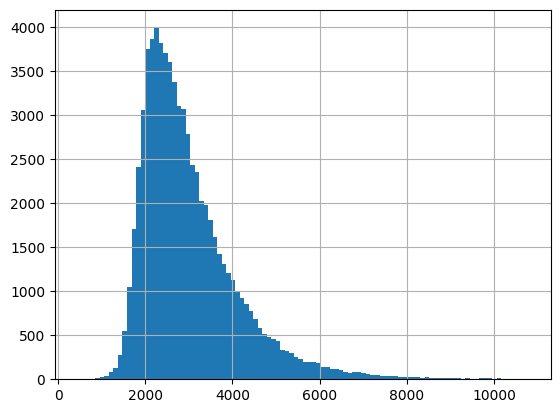

In [105]:
p4_ata_train.hist(bins=100)

<AxesSubplot: >

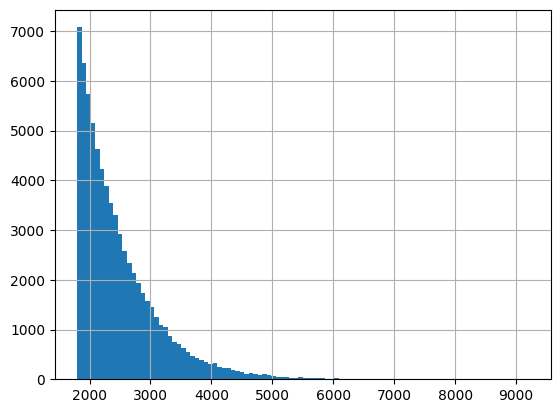

In [108]:
pd.Series(p4_eta_edd_h3_hour_train_transformed[:, 20]).hist(bins=100)

<AxesSubplot: >

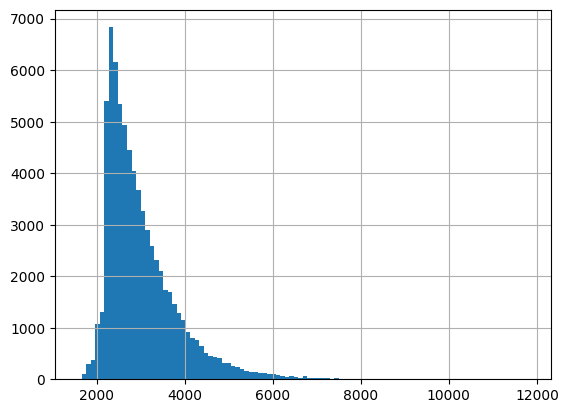

In [110]:
pd.Series(p4_ata_train_pred).hist(bins=100)

In [42]:
p4_ata_test_pred[p4_ata_test_pred < 0]

array([10384.93212894, 11295.37934212, 10795.75623542, 10370.39314336,
       10800.30462468, 10741.94658946])